# 1. Imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
O_df = O_df.drop('Unnamed: 0',axis=1)
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')

# 2. Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']

x = StandardScaler().fit_transform(O_df.drop(target,axis=1))
y = StandardScaler().fit_transform(O_df[target])

yScaler = StandardScaler()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

# 3. Model Definition

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

normalize = layers.Normalization()

normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

# 4. Loss Function analisis

### Mean Squared Logarithmic Error

In [5]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

VALIDAITON_LOSS = []
VALIDATION_MAE = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSLE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=20,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDAITON_LOSS.append(results['loss'])
	VALIDATION_MAE.append(results['MAE'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/20
207/207 [==============================] - 6s 10ms/step - loss: 0.0984 - MAE: 0.7543 - val_loss: 0.0700 - val_MAE: 0.6457
Epoch 2/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0499 - MAE: 0.5336 - val_loss: 0.0261 - val_MAE: 0.4296
Epoch 3/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0229 - MAE: 0.4151 - val_loss: 0.0207 - val_MAE: 0.3825
Epoch 4/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0187 - MAE: 0.3857 - val_loss: 0.0175 - val_MAE: 0.3529
Epoch 5/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0149 - MAE: 0.3641 - val_loss: 0.0129 - val_MAE: 0.3746
Epoch 6/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0123 - MAE: 0.3591 - val_loss: 0.0099 - val_MAE: 0.4034
Epoch 7/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0110 - MAE: 0.3553 - val_loss: 0.0118 - val_MAE: 0.3667
Epoch 8/20
207/207 [==============================] - 2s 9ms/step - loss: 0

In [7]:
print(np.sum(VALIDATION_MAE)/len(VALIDATION_MAE))

0.2583343297243118


### Mean Squared Error

In [8]:
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

VALIDATION_MAE = []
VALIDAITON_LOSS = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=20,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_MAE.append(results['MAE'])
	VALIDAITON_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/20
207/207 [==============================] - 3s 11ms/step - loss: 0.6102 - MAE: 0.6152 - val_loss: 0.4784 - val_MAE: 0.5237
Epoch 2/20
207/207 [==============================] - 2s 9ms/step - loss: 0.2721 - MAE: 0.3885 - val_loss: 0.1367 - val_MAE: 0.2796
Epoch 3/20
207/207 [==============================] - 2s 9ms/step - loss: 0.1195 - MAE: 0.2603 - val_loss: 0.0900 - val_MAE: 0.2242
Epoch 4/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0800 - MAE: 0.2119 - val_loss: 0.0749 - val_MAE: 0.2068
Epoch 5/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0659 - MAE: 0.1919 - val_loss: 0.0762 - val_MAE: 0.2081
Epoch 6/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0532 - MAE: 0.1711 - val_loss: 0.0429 - val_MAE: 0.1501
Epoch 7/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0458 - MAE: 0.1592 - val_loss: 0.0366 - val_MAE: 0.1393
Epoch 8/20
207/207 [==============================] - 2s 9ms/step - loss: 0

In [9]:
print(np.sum(VALIDATION_MAE)/len(VALIDATION_MAE))

0.08965537995100022


### Mean Absolute Error

In [10]:
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

VALIDATION_MAE = []
VALIDAITON_LOSS = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=20,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_MAE.append(results['MAE'])
	VALIDAITON_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/20
207/207 [==============================] - 3s 11ms/step - loss: 0.6186 - MAE: 0.6254 - val_loss: 0.4468 - val_MAE: 0.5236
Epoch 2/20
207/207 [==============================] - 2s 9ms/step - loss: 0.2091 - MAE: 0.3460 - val_loss: 0.1365 - val_MAE: 0.2835
Epoch 3/20
207/207 [==============================] - 2s 9ms/step - loss: 0.1180 - MAE: 0.2618 - val_loss: 0.1006 - val_MAE: 0.2402
Epoch 4/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0835 - MAE: 0.2188 - val_loss: 0.0939 - val_MAE: 0.2392
Epoch 5/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0684 - MAE: 0.1966 - val_loss: 0.0586 - val_MAE: 0.1844
Epoch 6/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0582 - MAE: 0.1798 - val_loss: 0.0579 - val_MAE: 0.1779
Epoch 7/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0526 - MAE: 0.1699 - val_loss: 0.0563 - val_MAE: 0.1786
Epoch 8/20
207/207 [==============================] - 2s 9ms/step - loss: 0

In [26]:
print(np.sum(VALIDATION_MAE)/len(VALIDATION_MAE))

0.1352931320667267


### Mean Aabsolute Percentage Error

In [205]:
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

VALIDATION_MAE = []
VALIDAITON_LOSS = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MAPE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=20,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_MAE.append(results['MAE'])
	VALIDAITON_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/20
207/207 [==============================] - 3s 11ms/step - loss: 91.5874 - MAE: 0.7713 - val_loss: 89.2599 - val_MAE: 0.7752
Epoch 2/20
207/207 [==============================] - 2s 9ms/step - loss: 87.0563 - MAE: 0.7199 - val_loss: 83.9696 - val_MAE: 0.7054
Epoch 3/20
207/207 [==============================] - 2s 9ms/step - loss: 78.2737 - MAE: 0.6200 - val_loss: 77.2241 - val_MAE: 0.6292
Epoch 4/20
207/207 [==============================] - 2s 9ms/step - loss: 71.0226 - MAE: 0.5440 - val_loss: 66.1789 - val_MAE: 0.5322
Epoch 5/20
207/207 [==============================] - 2s 9ms/step - loss: 64.9148 - MAE: 0.4799 - val_loss: 59.5054 - val_MAE: 0.4377
Epoch 6/20
207/207 [==============================] - 2s 9ms/step - loss: 60.6521 - MAE: 0.4331 - val_loss: 60.7883 - val_MAE: 0.4432
Epoch 7/20
207/207 [==============================] - 2s 9ms/step - loss: 55.6988 - MAE: 0.3909 - val_loss: 51.8495 - val_MAE: 0.3813
Epoch 8/20
207/207 [==============================] - 2s 9ms/

In [200]:
print(np.sum(VALIDATION_MAE)/len(VALIDATION_MAE))

0.21592542827129363


# 5. Ensemble

In [20]:
from keras.optimizers import Adam

NUM_MODELS = 10
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for model in models:
	optimizer = Adam()
	model.compile(loss='MSE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=10))

Epoch 1/10
259/259 [==============================] - 3s 9ms/step - loss: 0.5195
Epoch 2/10
259/259 [==============================] - 2s 8ms/step - loss: 0.1378
Epoch 3/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0916
Epoch 4/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0722
Epoch 5/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0599
Epoch 6/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0507
Epoch 7/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0443
Epoch 8/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0393
Epoch 9/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0336
Epoch 10/10
259/259 [==============================] - 2s 8ms/step - loss: 0.0290
Epoch 1/10
259/259 [==============================] - 3s 8ms/step - loss: 0.5714
Epoch 2/10
259/259 [==============================] - 2s 8ms/step - loss: 0.1593
Epoch 3/10
259/259 [=======

In [122]:
predictions = [model.predict(x_val) for model in models] # dim(predictions) = (num_models, num_rows, num_outputs)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


In [123]:
weights = [model.evaluate(x_val, y_val) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])


2/2 [==============================] - 0s 5ms/step - loss: 0.0357


In [124]:
def plot_posterior_density(X, ax, title='', color='green',alpha=0.1,linewidth=1):
    sns.kdeplot(X,fill=False, ax=ax, color=color,alpha=alpha,linewidth=linewidth)
    #ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_xlabel('X')
    ax.set_ylabel('Densidad')
    ax.set_title(title)

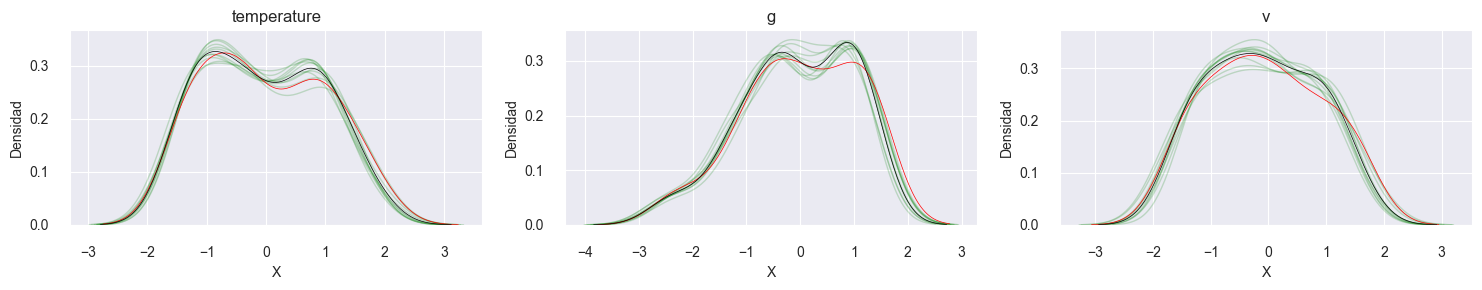

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for i, featureName in enumerate(target):
  for j in range(NUM_MODELS):
    plot_posterior_density(predictions[j][:,i], axes[i], featureName,alpha=0.2)
    
  #upperBound = ensemble_prediction[:,i] + uncertainty[:,i]
  #lowerBound = ensemble_prediction[:,i] - uncertainty[:,i]
  plot_posterior_density(y_val[:,i], axes[i], featureName, color='red', alpha=1,linewidth=0.5,label='Test')
  plot_posterior_density(ensemble_prediction[:,i], axes[i], featureName, color='black', alpha=1,linewidth=0.5,label='Ensemble')
  #plot_posterior_density(upperBound, axes[i], featureName, color='black', alpha=1,linewidth=0.5)
  #plot_posterior_density(lowerBound, axes[i], featureName, color='black', alpha=1,linewidth=0.5)

plt.tight_layout()
plt.show()